Reducing dimension has various advantages of it's own:

    1. Can help make the model faster because less features to consider.

    2. Remove noise present in the data due to unwanted features.

    3. Aids visualization




It also has some disadvantages:

    1. May affect model performance adversely.

    2. No one size - fits all solution.

In [1]:
'''
    Method 1: PCA (Principal Component Analysis)
        The idea behind PCA is to reduce the dimensionality of the data while preserving as much variance as possible.
        PCA identifies the directions (principal components) in which the data varies the most and projects the data onto these components.
        This is particularly useful for visualizing high-dimensional data in 2D or 3D space.

        The following code shows the mathematical application for PCA.
'''

'\n    Method 1: PCA (Principal Component Analysis)\n        The idea behind PCA is to reduce the dimensionality of the data while preserving as much variance as possible.\n        PCA identifies the directions (principal components) in which the data varies the most and projects the data onto these components.\n        This is particularly useful for visualizing high-dimensional data in 2D or 3D space.\n\n        The following code shows the mathematical application for PCA.\n'

In [124]:
import numpy as np
from sklearn import datasets

data = datasets.make_low_rank_matrix(n_samples=10000, n_features=200, effective_rank=70, tail_strength=0.1, random_state=42)
X = data

In [125]:
X_centered = X - np.mean(X, axis=0) # PCA assumes data is centered around the origin. Make sure to center the data first.
U, S, Vt = np.linalg.svd(X_centered)    # SVD decomposes the centered data matrix into three matrices: U, S, and Vt as follows: X = U * S * Vt
V = Vt.T
c1_ = V[:, 0]
c2_ = V[:, 1]

In [157]:
# Projecting the data onto tthe first n-principal components
n = 3 # Number of principal components to keep
Wd = V[:, :n] # Wd is the matrix of the first n principal components
X_projected = X_centered.dot(Wd) # Project the data onto the first n principal components

In [127]:
# Using sklearn for PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=5) # Create a PCA object with the desired number of components
X_decomposed = pca.fit_transform(X) # Fit the PCA model to the data

# Finding variance ratios
preserved_variance_ratio = pca.explained_variance_ratio_
total_variance_preserved = np.sum(preserved_variance_ratio)
print(f"Preserved Variance Ratio: {preserved_variance_ratio}")
print(f"Total Variance Preserved: {total_variance_preserved}")
print(f"Variance lost: {1 - total_variance_preserved}")

Preserved Variance Ratio: [0.0207841  0.02077164 0.02073929 0.02069523 0.0206378 ]
Total Variance Preserved: 0.1036280525570685
Variance lost: 0.8963719474429315


In [128]:
# Finding the optimal number of components
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # Find the number of components that preserve at least 95% of the variance
print(f"Optimal number of components to preserve 95% variance: {d}")

Optimal number of components to preserve 95% variance: 83


In [122]:
# Better way to find the optimal number of components
pca = PCA(n_components=0.95) # Automatically select the number of components that preserve at least 95% of the variance
X_reduced = pca.fit_transform(X) # Fit the PCA model to the data and reduce the dimensionality

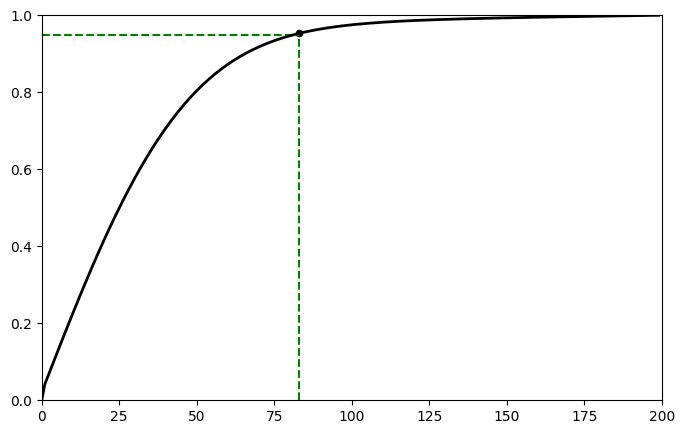

In [139]:
# Plotting the cumulative explained variance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.axis([0, 200, 0, 1])
cumsum.put(0, 0)  # Insert 0 at the beginning for the cumulative sum
plt.axhline(y=0.95, color='g', linestyle='--', xmax=d/len(cumsum), label='95% Variance')
plt.axvline(x=d, color='g', linestyle='--', ymax=0.95, label=f'Optimal Components: {d}')
plt.plot(cumsum, 'k-', linewidth=2)
plt.scatter([d], [cumsum[d]], color='k', s=20)
plt.show()

Conclusion: Much of the variance can be preserved using just about 100 components (83 components can preseve ~95%)

In [141]:
'''
    Restoration error
    The restoration error is the difference between the original data and the reconstructed data after applying PCA.
    It can be calculated as follows:
    restoration_error = np.linalg.norm(X - X_restored, axis=1)
'''

pca = PCA(n_components=100) # Create a PCA object with the desired number of components
X_decomposed = pca.fit_transform(X) # Fit the PCA model to the data
X_restored = pca.inverse_transform(X_decomposed) # Reconstruct the original data
restoration_error = np.linalg.norm(X - X_restored, axis=1) # Calculate the restoration error
print(f"Restoration Error: {restoration_error.mean()}") # Print the mean restoration error

Restoration Error: 0.011059430773199711


In [143]:
# Randomized PCA for faster computation
# Just set the svd_solver to 'randomized' in the PCA object. By default, it uses 'auto'. Auto uses randomized solver when d is less than 80% of n or m. Set svd_solver to 'full' to use the full SVD solver.
rnd_pca = PCA(n_components=100, svd_solver='randomized') # Create a randomized PCA object with the desired number of components
X_rnd_decomposed = rnd_pca.fit_transform(X) 
X_rnd_restored = rnd_pca.inverse_transform(X_rnd_decomposed) 
rnd_restoration_error = np.linalg.norm(X - X_rnd_restored, axis=1)
print(f"Randomized Restoration Error: {rnd_restoration_error.mean()}") # Much faster but only slightly less accurate than the standard PCA

Randomized Restoration Error: 0.011061815836101116


In [145]:
# INCREMENTAL PCA
# Incremental PCA is useful for large datasets that do not fit into memory.
# It works by iteratively fitting the PCA model to smaller subsets (mini-batches) of the data.

In [146]:
from sklearn.decomposition import IncrementalPCA
n_batches = 10 # Number of mini-batches
ipca = IncrementalPCA(n_components=100) 
for batch in np.array_split(X, n_batches):
    ipca.partial_fit(batch)
X_reduced = ipca.transform(X)

In [155]:
# Writing X to a file and reading it back using memmap
with open('data.dat', 'w') as f:
    X.astype('float32').tofile(f)  # Save the data to a file in binary format

In [160]:
# Another method to split the data (file-format) into mini-batches is to use memmap
X_data = np.memmap('datasets/data.dat', dtype='float32', mode='readonly', shape=(10000, 200)) # Load the data from a file
n_batches = 100
batch_size = X_data.shape[0] // n_batches  # Calculate the batch size
inc_pca = IncrementalPCA(n_components=100, batch_size=batch_size)
inc_pca.fit(X_data)
X_reduced = inc_pca.transform(X_data)